# A/B testing: conversion rate

Loading data from disk

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("raw_data.csv")
print("Number of visits =", df.shape[0])
df.head()

Number of visits = 294478


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## Exploratory Data Analysis and Data preparation

Let's primarally explore our features. For each feature we want to display:
 - number of unique values, 
 
 - range of values, 
 
 - number of missing values, 
 
 - a few examples of values

In [2]:
summary = pd.DataFrame(index=df.columns, columns=["# unique", "range", "# missing", "examples"])
for name in df.columns:
    summary.loc[name, "# unique"] = df[name].nunique()
    summary.loc[name, "range"] = [df[name].max(), df[name].min()]
    summary.loc[name, "# missing"] = df[name].isna().sum()
    summary.loc[name, "examples"] = df[name].unique()[:2]
summary

,# unique,range,# missing,examples
user_id,290584,"[945999, 630000]",0,"[851104, 804228]"
timestamp,294478,"[2017-01-24 13:41:54.460509, 2017-01-02 13:42:...",0,"[2017-01-21 22:11:48.556739, 2017-01-12 08:01:..."
group,2,"[treatment, control]",0,"[control, treatment]"
landing_page,2,"[old_page, new_page]",0,"[old_page, new_page]"
converted,2,"[1, 0]",0,"[0, 1]"


Next, we should figure out, how features "group" and "landing_page" are connected. 
We expect each user from control group to land on the old page. Analogically for users from treatment group.

In [3]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


Ooops. Apparently, there are users that landed at wrong page by mistake. Removing visits by mistake:

In [4]:
mask =  ((df["group"] == "control")   & (df["landing_page"] =="old_page")) | \
        ((df["group"] == "treatment") & (df["landing_page"] =="new_page"))

df = df[mask]

# check: must not contain "new_page"
print(df[df["group"] == "control"]["landing_page"].unique())

['old_page']


Okay. 

We go further. There may be users with 2 or more visits.

In [5]:
counts = pd.DataFrame(df["user_id"], index = df.index)
counts = counts["user_id"].value_counts()
ids = counts[counts > 1].index.values
df_recurring = df.loc[df['user_id'].isin(ids)]

counts.head()

773192    2
630732    1
811737    1
797392    1
795345    1
Name: user_id, dtype: int64

Strategy: delete all duplicate visits except one.

In [6]:
ind_to_drop = []
for user_id in ids:
    for group in ["control", "treatment"]:
        for landing_page in ["old_page", "new_page"]:
            for converted in [0, 1]:
                arr  = (df_recurring.loc[(df_recurring["user_id"]==user_id) & 
                                        (df_recurring["group"]==group) & 
                                        (df_recurring["landing_page"]==landing_page) & 
                                        (df_recurring["converted"]==converted)]
                                    .index[:1]
                       )
                if len(arr) == 1:
                    ind_to_drop.append(arr[0])
                    
print("We drop the following recurring visits : ", ind_to_drop)
df = df[~df["user_id"].isin(ind_to_drop)]

We drop the following recurring visits :  [1899]


Next,we want to detect seasonality in time series of CR.

In [7]:
df["day"] = pd.to_datetime(df["timestamp"]).dt.day

conv_days = (df[["day", "group", "converted"]]
              .groupby(["group", "day"])
              .agg(["mean", "size"])
             )
conv_days.columns = ["conv_rate", "size"]
control_days = conv_days.loc["control"]
treatment_days = conv_days.loc["treatment"]
conv_days.head()

conv_rate  size
group   day                 
control 2     0.125568  2859
        3     0.113809  6590
        4     0.121922  6578
        5     0.123230  6427
        6     0.115350  6606

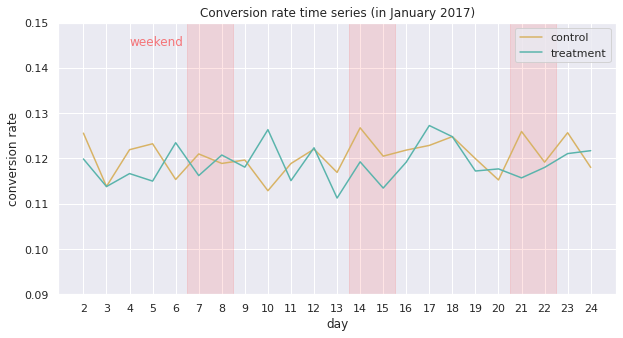

In [8]:
fig = plt.figure(figsize=(10, 5))
sns.set_theme()
plt.plot(control_days.index, control_days["conv_rate"], label="control", color="#d8b365")
plt.plot(treatment_days.index, treatment_days["conv_rate"], label="treatment", color= "#5ab4ac")
plt.xticks(control_days.index)
plt.ylim(0.09, 0.15)
plt.xlabel("day")
plt.ylabel("conversion rate")
plt.title("Conversion rate time series (in January 2017)")
ax=plt.gca()

for weekend in [6.5, 8.5], [13.5, 15.5], [20.5, 22.5]:
    ax.fill_between(weekend, [1, 1], 
                color='red', alpha=0.1)
    
plt.text(4, 0.145, "weekend", fontsize=12, color="red", alpha=0.5)

plt.legend();

We suspect increasing of CR of control group and decresing CR of treatment group in 14 and 15 January (Saturday and Sunday).

By days of week:

In [9]:
df["day"] = pd.to_datetime(df["timestamp"]).dt.dayofweek

conv_days = (df[["day", "group", "converted"]]
              .groupby(["group", "day"])
              .agg(["mean", "size"])
             )

conv_days.columns = ["conv_rate", "size"]
conv_days.reset_index(inplace=True)
conv_days


,group,day,conv_rate,size
0,control,0,0.122795,22794
1,control,1,0.116748,23615
2,control,2,0.121835,19748
3,control,3,0.121729,19527
4,control,4,0.115834,19692
5,control,5,0.124567,19901
6,control,6,0.119518,19997
7,treatment,0,0.119491,22646
8,treatment,1,0.122339,23533
9,treatment,2,0.118837,19817


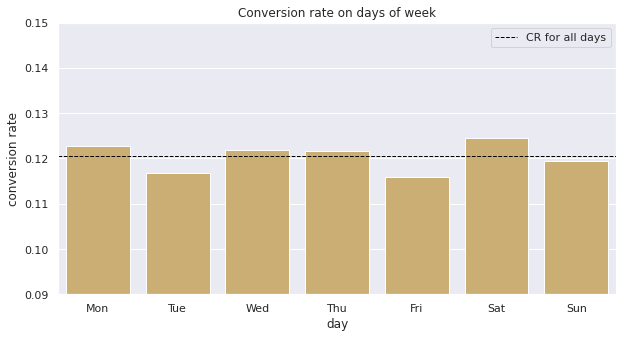

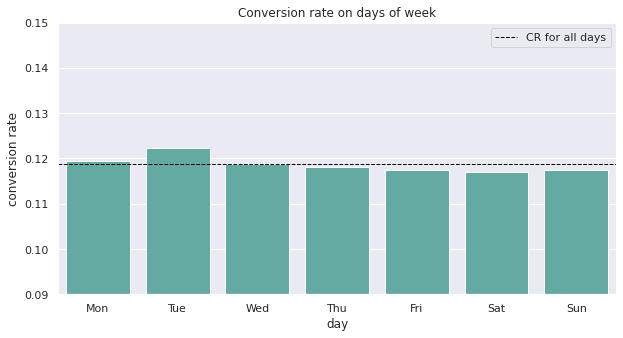

In [10]:

def plot_cr_days(group_name):
    data = conv_days[conv_days["group"]==group_name]
    mean_cr = data["conv_rate"].mean() 
    
    fig = plt.figure(figsize=(10, 5))
    plt.axhline(mean_cr, 
                color="black", 
                linestyle="--", 
                linewidth=1, 
                label="CR for all days")

    color = "#d8b365" if (group_name == "control") else "#5ab4ac"
    sns.barplot(x="day", y="conv_rate",
                data=data, 
                color=color)
    plt.grid(axis="y", color="white")
    ax = plt.gca()
    ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_axisbelow(True)
    plt.ylim(0.09, 0.15)

    plt.title("Conversion rate on days of week")
    plt.ylabel("conversion rate")
    plt.legend()
    plt.show()

    
plot_cr_days("control")
plot_cr_days("treatment")

We don't observe any seasonality by week day.

In [17]:
df.to_csv("cleaned_data.csv")

## Visualization: conversion rate of two groups


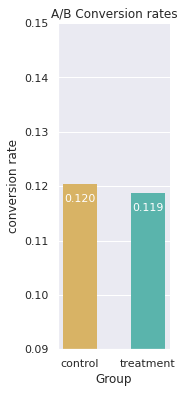

In [11]:
agg = df[["converted", "group"]].groupby("group").aggregate(["mean", "size", "sum"])
agg.columns = ["conv_rate", "size", "count"]

# plotting
fig = plt.figure(figsize=(2, 6))
rects = plt.bar(x=agg.index, 
                height=agg["conv_rate"], 
                width=[0.5, 0.5],
                color=["#d8b365", "#5ab4ac"], edgecolor=(0, 0, 0, 0))
# customizing plot
plt.grid(False)
plt.grid(axis='y', color="white")
plt.ylim(0.09, 0.15);
plt.xlabel("Group")
plt.ylabel("conversion rate");
plt.title("A/B Conversion rates")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=True) # labels along the bottom edge are off
ax.set_axisbelow(True)

# text on bars
for i in [0, 1]:
    height = rects[i].get_height()
    plt.annotate("{:.3f}".format(agg.iloc[i]["conv_rate"]), 
                 xy=(rects[i].get_x() + rects[i].get_width() / 2, height-0.004),
                 xytext=(0, 2),
                 fontsize=11,
                 textcoords="offset points",
                 ha='center', 
                 va='bottom', 
                 color="white")

## Testing the hypothesis

Before performing statistical test, we should calculate a required size of sample. 

Our goal is to be able to detect difference in 0.02 with probability 0.8 (it's called a power of test). Another parameter we mush choose by hands is $\alpha$ - the level of significance (probability of type I error). Common choise is $\alpha = 0.05$.

In [13]:
# compute standartized effect size
from statsmodels.stats.proportion import proportion_effectsize

n1 = agg.loc["control", "size"]
n2 = agg.loc["treatment", "size"]
p1 = agg.loc["control", "conv_rate"]
p2 = agg.loc["treatment", "conv_rate"]
# we want to capture change  in 0.02
effect_size = proportion_effectsize(p1, p1+0.02)

# calculating required sqmple size
from statsmodels.stats.power import NormalIndPower
alpha = 0.05
print("alpha      = {:.3f}".format(alpha))
# assume standard deviations of p1 and p2 are equal 
required_n = NormalIndPower().solve_power(effect_size=effect_size, 
                                          alpha=alpha, 
                                          nobs1=None, 
                                          ratio=1, 
                                          power=0.8)
required_n = np.ceil(required_n).astype(int)
print("required n =", required_n)

control_sample = df[df["group"]=="control"].sample(required_n)
treatment_sample = df[df["group"]=="treatment"].sample(required_n)

alpha      = 0.050
required n = 4444


Next - performing z-test. Our null hypothesis:
$$H_0: p_1 = p_2$$
with two-tailed alternative:
$$H_1: p_1 \neq p_2$$

In [14]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


count = [control_sample["converted"].sum(),
         treatment_sample["converted"].sum()]
nobs = [control_sample.shape[0],
        treatment_sample.shape[0]]
# perform z-test
z_stat, p_val = proportions_ztest(count, nobs)
# confidence intervals for true proportions
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(count, nobs, alpha)

Reporting the results:

In [15]:
print("z-statistic  = {:.3f}".format(z_stat))
print("p-value      = {:.3f}".format(p_val))
print("{:}% ci for conversion rate of control group   = ({:.4f}, {:.4f})"
      .format(int((1-alpha)*100), lower_con, upper_con))
print("{:}% ci for conversion rate of treatment group = ({:.4f}, {:.4f})"
      .format(int((1-alpha)*100), lower_treat, upper_treat))


z-statistic  = 0.263
p-value      = 0.793
95% ci for conversion rate of control group   = (0.1095, 0.1286)
95% ci for conversion rate of treatment group = (0.1078, 0.1267)


## Conclusion

p-value is much larger than $\alpha=0.05$.
Therefore, we can not reject the null hypothesis.


We conclude that conversions rates in both groups are the same.
Data doesn't show significant difference between two groups.